In [1]:
import os
import os.path as osp
import pickle

import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

from mujoco_py import const
import wrappers
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import numpy as np
import torch
import torch.nn.functional as F

"""MLP Reward Predictor"""
import torch
from torch import nn

from garage.torch.modules import MLPModule

In [2]:

class MLPRewardPredictor(nn.Module):
    """Gaussian MLP Value Function with Model.
    It fits the input data to a gaussian distribution estimated by
    a MLP.
    Args:
        env_spec (EnvSpec): Environment specification.
        hidden_sizes (list[int]): Output dimension of dense layer(s) for
            the MLP for mean. For example, (32, 32) means the MLP consists
            of two hidden layers, each with 32 hidden units.
        hidden_nonlinearity (callable): Activation function for intermediate
            dense layer(s). It should return a torch.Tensor. Set it to
            None to maintain a linear activation.
        hidden_w_init (callable): Initializer function for the weight
            of intermediate dense layer(s). The function should return a
            torch.Tensor.
        hidden_b_init (callable): Initializer function for the bias
            of intermediate dense layer(s). The function should return a
            torch.Tensor.
        output_nonlinearity (callable): Activation function for output dense
            layer. It should return a torch.Tensor. Set it to None to
            maintain a linear activation.
        output_w_init (callable): Initializer function for the weight
            of output dense layer(s). The function should return a
            torch.Tensor.
        output_b_init (callable): Initializer function for the bias
            of output dense layer(s). The function should return a
            torch.Tensor.
        learn_std (bool): Is std trainable.
        init_std (float): Initial value for std.
            (plain value - not log or exponentiated).
        layer_normalization (bool): Bool for using layer normalization or not.
        name (str): The name of the value function.
    """

    def __init__(self,
                 input_dim,
                 hidden_sizes=(32, 32),
                 hidden_nonlinearity=torch.tanh,
                 hidden_w_init=nn.init.xavier_uniform_,
                 hidden_b_init=nn.init.zeros_,
                 output_nonlinearity=None,
                 output_w_init=nn.init.xavier_uniform_,
                 output_b_init=nn.init.zeros_,
                 layer_normalization=False,
                 name='MLPRewardPredictor'):

        super().__init__()

        output_dim = 1

        self.name = name

        self.module = MLPModule(
            input_dim=input_dim,
            output_dim=output_dim,
            hidden_sizes=hidden_sizes,
            hidden_nonlinearity=hidden_nonlinearity,
            hidden_w_init=hidden_w_init,
            hidden_b_init=hidden_b_init,
            output_nonlinearity=output_nonlinearity,
            output_w_init=output_w_init,
            output_b_init=output_b_init,
            layer_normalization=layer_normalization)

    def predict_preferences(self, left_segs, right_segs):
        if not left_segs.shape == right_segs.shape:
            raise ValueError('Left and Right segs should have the same shape')
        assert left_segs.ndim == 2
        
        batch_size, obs_dim = left_segs.shape

#         inp = torch.cat([left_segs, right_segs])
#         logits = self.module(inp).reshape(2, batch_size).T
        
        left_out = self.module(left_segs)
        right_out = self.module(right_segs)
        logits = torch.cat([left_out, right_out], dim=1)
        
        preds = torch.argmax(logits, dim=1)
        return logits, preds

#     def compute_preference_loss(self, left_segs, right_segs, prefs, device='cpu'):
#         if not left_segs.shape == right_segs.shape:
#             raise ValueError('Left and Right segs should have the same shape')

#         batch_size, segment_length, obs_dim = left_segs.shape

#         inp = (torch.cat([left_segs, right_segs])
#                     .reshape(2 * batch_size * segment_length, obs_dim)
#                     .to(device))


#         output = (self.module(inp)
#                       .reshape(2*batch_size, segment_length)
#                       .sum(dim=1))

#         logits = output.reshape(2, batch_size).transpose(0, 1)
#         preds = torch.argmax(logits, dim=1)
#         accuracy = torch.sum(preds.flatten() == prefs.flatten()) / batch_size

#         loss = nn.functional.cross_entropy(logits, prefs)
#         return loss, accuracy

#     def propagate_preference_loss(self, left_segs, right_segs, prefs, device='cpu'):
#         r"""Compute mean value of loss.
#         Args:
#             obs (torch.Tensor): Observation from the environment
#                 with shape :math:`(N \dot [T], O*)`.
#             returns (torch.Tensor): Acquired returns with shape :math:`(N, )`.
#         Returns:
#             torch.Tensor: Calculated negative mean scalar value of
#                 objective (float).
#         """
#         loss, accuracy = self.compute_preference_loss(left_segs, right_segs, prefs, device)
#         loss.backward()
#         return loss, accuracy

#     def propagate_ranking_loss(self, segs, ranks):
#         preds = self.module(segs)
#         loss = nn.functional.mse_loss(preds, ranks.reshape(-1,1))
#         loss.backward()
#         return loss

    # pylint: disable=arguments-differ
    def forward(self, obs):
        r"""Predict value based on paths.
        Args:
            obs (torch.Tensor): Observation from the environment
                with shape :math:`(P, O*)`.
        Returns:
            torch.Tensor: Calculated baselines given observations with
                shape :math:`(P, O*)`.
        """
        return self.module(obs)

In [3]:
EXP = 'DIVERSITY_ALPHA_05_Mon_Feb__1_09:36:50_2021'
EPOCH = 200
EPISODES = osp.join('./experiment', EXP, 'episode_logs', f'episode_{str(EPOCH)}.pkl')
ENV = osp.join('./experiment', EXP, 'env.pkl')

with open(EPISODES, 'rb') as f:
    episodes = pickle.load(f)
    
with open(ENV, 'rb') as f:
    env = pickle.load(f)

/opt/conda/lib/python3.8/site-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


In [4]:
space = env.spec.observation_space
observations = np.array([space.flatten_with_keys(x, keys=['state']) for x in episodes.observations[::5]])
observations = torch.tensor(observations.astype(np.float32))
rewards = episodes.env_infos['gt_reward'][::5]
total_ordering = np.argsort(rewards)

In [5]:

class PreferenceGenerator:
    
    def __init__(self, ordered_states, batch_size=256):
        self.ordered_states = ordered_states
        self.batch_size = batch_size
        self.update()
        
    def update(self):
        length = len(self.ordered_states)
        mid = length // 2
        permutation = np.random.permutation(length)
        self._left_ids = permutation[:mid]
        self._right_ids = permutation[mid:2*mid]
        self._prefs = torch.tensor((self._right_ids > self._left_ids).astype(int))
        self._num_batches = mid // self.batch_size
        
    def get_minibatch(self):
        for itr in range(self._num_batches):
            batch_start = itr * self.batch_size
            batch_end = (itr + 1) * self.batch_size
            left_ids = self._left_ids[batch_start: batch_end]
            right_ids = self._right_ids[batch_start: batch_end]
            prefs = self._prefs[batch_start: batch_end]
            left_segs = self.ordered_states[left_ids]
            right_segs = self.ordered_states[right_ids]
            yield left_segs, right_segs, prefs
        self.update()


In [6]:
reward_predictor = MLPRewardPredictor(
    input_dim=76,
    hidden_sizes=(256, 256),
#     layer_normalization=True,
    hidden_nonlinearity=F.relu,
)

pref_generator = PreferenceGenerator(observations[total_ordering], batch_size=64)

EPOCHS = 100

optimizer = torch.optim.Adam(reward_predictor.parameters(), lr=0.001)

for epoch in range(1000):
    correct = 0
    total = 0
    
    for left_segs, right_segs, prefs in pref_generator.get_minibatch():
        optimizer.zero_grad()
        logits, preds = reward_predictor.predict_preferences(left_segs, right_segs)
        
        correct += torch.sum(preds.flatten() == prefs.flatten())
        total += len(preds)
        loss = nn.functional.cross_entropy(logits, prefs)      
        loss.backward()
        optimizer.step()
#         print(f'Loss: {loss}')
    if epoch % 50 == 0:
        print(f'Accuracy: {correct/total}')

/opt/conda/lib/python3.8/site-packages/torch/autograd/__init__.py:130: UserWarning: CUDA initialization: Found no NVIDIA driver on your system. Please check that you have an NVIDIA GPU and installed a driver from http://www.nvidia.com/Download/index.aspx (Triggered internally at  /opt/conda/conda-bld/pytorch_1607369981906/work/c10/cuda/CUDAFunctions.cpp:100.)
  Variable._execution_engine.run_backward(


Accuracy: 0.78125
Accuracy: 0.9627016186714172
Accuracy: 0.9737903475761414
Accuracy: 0.9788306355476379
Accuracy: 0.9784946441650391
Accuracy: 0.9850470423698425
Accuracy: 0.9808467626571655


KeyboardInterrupt: 

In [ ]:
########################

In [32]:
episodes.env_infos['state'][0]

array([ 0.        ,  0.        ,  0.        ,  0.        , -1.3       ,
        0.9       ,  0.19996   , -0.01105464,  0.        ,  0.        ,
        0.9999389 ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ])

In [35]:
# states = np.mgrid[-1:4:80j,-2:2:80j].T.reshape(-1,2)
states = episodes.env_infos['state'][::5]

env.reset()
state = env.world.sim.get_state()
positions = []
observations = []

# for x, y in states:
#     state.qpos[0] = x
#     state.qpos[1] = y
#     env.world.sim.set_state(state)
for state in states:
    env.world.sim.set_state_from_flattened(state)
    observations.append(env.obs())
    positions.append(env.robot_pos)

In [36]:
obs = torch.tensor(np.stack(observations)).type(torch.float32)
pred_rewards = []

i = 0
while i < len(obs):
    start = i
    end = i + 2048
    
    pred_rewards.append(
        reward_predictor(obs[start:end])
    )
    
    i += 2048

pred_rewards = torch.cat(pred_rewards)

In [38]:
clipped_pred_rewards = np.clip(pred_rewards.detach().numpy(), -3, None)
# clipped_pred_rewards = pred_rewards
scaled_rewards = (clipped_pred_rewards - clipped_pred_rewards.min())
scaled_rewards /= scaled_rewards.max()

In [39]:
scaled_rewards.max()

1.0

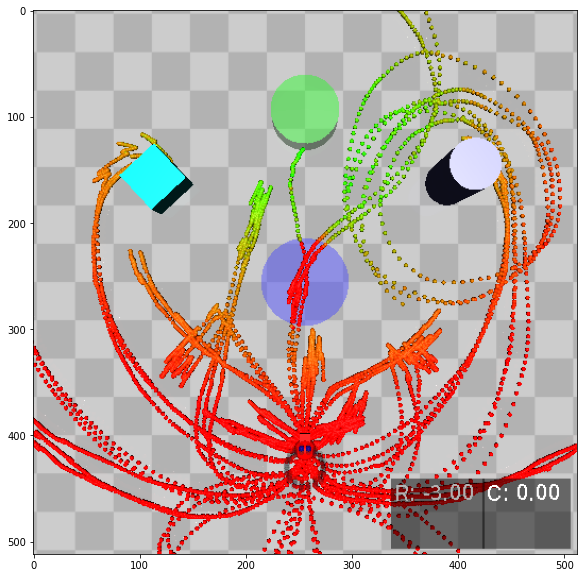

In [40]:
env.reset()
env.render('rgb_array')
for pos, reward in zip(positions, scaled_rewards):
    color = np.array([1-reward, reward, 0, 1])
    env.viewer.add_marker(pos=pos,
                          size=0.02 * np.ones(3),
                          type=const.GEOM_SPHERE,
                          rgba=color,
                          label='')

render = env.render('rgb_array')
figure(figsize=(10,10))
plt.imshow(render)

In [ ]:
########################

In [7]:
obs = torch.tensor([space.flatten_with_keys(x, keys=['state']) for x in episodes.observations]).type(torch.float32)
pred_rewards = []

i = 0
while i < len(obs):
    start = i
    end = i + 2048
    
    pred_rewards.append(
        reward_predictor(obs[start:end])
    )
    
    i += 2048

pred_rewards = torch.cat(pred_rewards)

In [8]:
states = episodes.env_infos['state']
clipped_pred_rewards = np.clip(pred_rewards.detach().numpy(), -3, None)
# clipped_pred_rewards = pred_rewards
scaled_rewards = (clipped_pred_rewards - clipped_pred_rewards.min())
scaled_rewards /= scaled_rewards.max()

In [9]:
env.reset()
positions = []
for state in states:
    env.world.sim.set_state_from_flattened(state)
    env.sim.forward()
    positions.append(env.robot_pos)

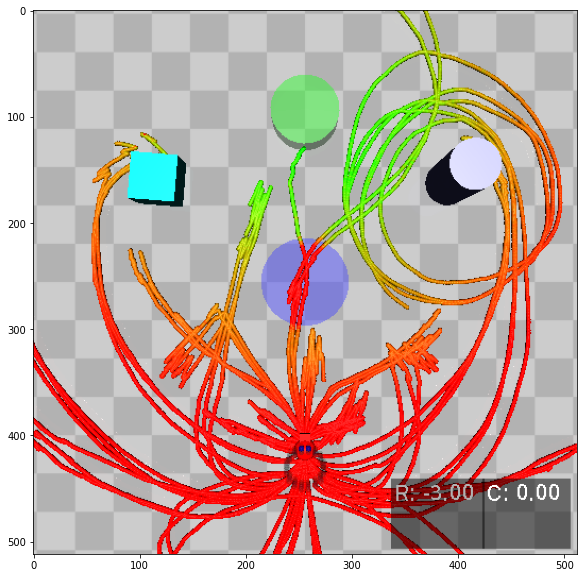

In [10]:
env.reset()
env.render('rgb_array')
for pos, gt_reward in zip(positions, scaled_rewards):
    color = np.array([1-gt_reward, gt_reward, 0, 1])
    env.viewer.add_marker(pos=pos,
                          size=0.02 * np.ones(3),
                          type=const.GEOM_SPHERE,
                          rgba=color,
                          label='')

render = env.render('rgb_array')
figure(figsize=(10,10))
plt.imshow(render)